# MATH50003 (2023–24)
# Lab 6: III.3 Cholesky Factorisation and III.4 Polynomial Regression

In this lab we explore using LU, PLU and Cholesky factorisations, and
implement algorithms for computing a Cholesky factorisation. We explore
stability properties of these different factorisations, and see that the
Cholesky factorisation is a robust way of determining if a matrix is symmetric
postive definite.

We also explore polynomial interpolation and regression, and see that when
interpolating at an evenly spaced grid one can encounter issues with convergence.
This is overcome via regression, but we are left with the question of how to
solve the underlying least squares problems.

**Learning Outcomes**

Mathematical knowledge:

1. Cholesky and reverse Cholesky factorisations, including for banded matrices.
2. Vandermonde matrices and least squares.
3. Issues with interpolation at evenly spaced points with functions with small radii of convergence.

Coding knowledge:

1. Using the `lu` and `cholesky` functions.
2. Solving least squares problems via `\`.

We load the following packages:

In [1]:
using LinearAlgebra, Plots, Test

### III.3 LU and Cholesky Factorisations

LU, PLU and Cholesky factorisations are closely related
matrix factorisations that reduce a square matrix to a product of
lower and upper triangular matrices, possibly with a permutation matrix.
We will only focus on the practical usage of LU and PLU, without digging into the
details of implementation. For the Cholesky factorisation we will look at implementation.

### III.3.1 LU Factorisation

If $A ∈ 𝔽^{n × n}$ is a square matrix where $𝔽$ is a field ($ℝ$ or $ℂ$)
then we can sometimes find lower and upper triangular matrices $L,U ∈ 𝔽^{n × n}$ such that
$$
A = LU.
$$
This is equivalent to Gaussian elimination but we will only focus on practical usage in this lab.
This factorisation can be computed using the `lu` function, but as the default is a PLU factorisation we add a flag
telling it not to use pivoting/permutations:

In [2]:
A = [1.0 1 1;
     2   4 8;
     1   4 9]

L,U = lu(A, NoPivot()) # NoPivot is a flag that tells lu to not use permutations

LU{Float64, Matrix{Float64}, Vector{Int64}}
L factor:
3×3 Matrix{Float64}:
 1.0  0.0  0.0
 2.0  1.0  0.0
 1.0  1.5  1.0
U factor:
3×3 Matrix{Float64}:
 1.0  1.0   1.0
 0.0  2.0   6.0
 0.0  0.0  -1.0

This matches what we derived by hand in the notes and indeed:

In [3]:
@test A ≈ L*U

Test Passed

We can use an LU factorisation to reduce solving a linear system to inverting triangular matrices:

In [4]:
b = randn(3)
c = L \ b # computed using forward elimination (even though L is a Matrix, \ detects it is lower triangular)
x = U \ c # computed using back substitution
@test A \ b ≈ x

Test Passed

If a matrix has a zero on a pivot we know by equivalence to Gaussian elimination that an LU factorisation
does not exist:

In [5]:
A[1,1] = 0
lu(A, NoPivot()) # throws an error

ZeroPivotException: ZeroPivotException: factorization encountered one or more zero pivots. Consider switching to a pivoted LU factorization.

But even if it has a very small but non-zero entry we get huge errors:

In [6]:
A[1,1] = 1E-14
L,U = lu(A, NoPivot()) # Succeeds but suddenly U is on order of 2E14!

LU{Float64, Matrix{Float64}, Vector{Int64}}
L factor:
3×3 Matrix{Float64}:
 1.0     0.0  0.0
 2.0e14  1.0  0.0
 1.0e14  0.5  1.0
U factor:
3×3 Matrix{Float64}:
 1.0e-14   1.0      1.0
 0.0      -2.0e14  -2.0e14
 0.0       0.0      3.0

In [7]:
norm(A \ b - U\(L\b)) # Very large error! A \ b uses pivoting now.

0.00340899690069259

**WARNING** The parantheses are important: algebra is left-associative so had we written `U\L\b` this would have been interpreted as
`(L\U) \ b` which would have meant `inv(inv(L)*U)*b == U \ (L*b)`.

-----

**Problem 1** For `A` defined above, consider setting  `A[1,1] = ε` for `ε = 10.0 ^ (-k)` for `k = 0,…,14`
with the right-hand side `b = [1,2,3]`.
Plot, scaling the $y$-axis logarithmically, the growth rate in the error of using LU compared to `\`.
Make a conjecture on how the error grows as $k → ∞$.
Hint: you can either allocate a vector of errors that is populated in a for-loop or write a simple comprehension.

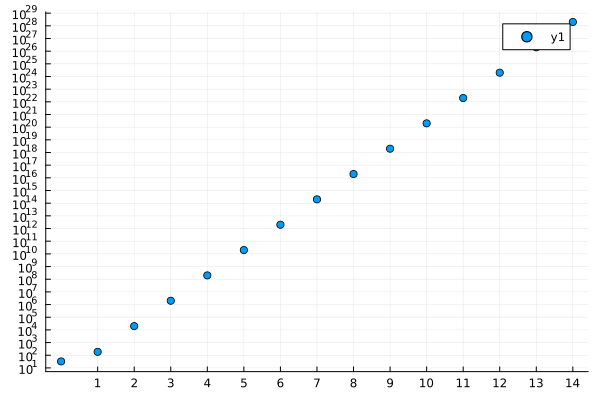

In [8]:
# TODO: Do a log-log plot for A with its 1,1 entry set to different ε and guess the growth rate.
# SOLUTION

A = [1.0 1 1;
     2   4 8;
     1   4 9]

b = [1,2,3]


n = 15
errs = zeros(n)
for k = 1:n
    A[1,1] = 10.0 ^ (1-k)
    L,U = lu(A, NoPivot())
    errs[k] = norm(A\b - L \ (U \ b))
end

scatter(0:n-1, errs; yscale=:log10, yticks = 10.0 .^ (0:30), xticks = 1:15)
# The error grows exponentially, like 10^(2k)

# END

**Problem 2(a)** Consider the Helmholtz equations
$$
\begin{align*}
u(0) &= 0 \\
u(1) &= 0 \\
u'' + k^2 u &= {\rm e}^x
\end{align*}
$$
discretised with finite-differences to result in a tridiagonal system.
Use the `lu` function without pivoting to
compute the LU factorization of the tridiagonal matrix. What sparsity structure
do you observe in `L` and `U`? Does this structure depend on $n$ or $k$?

In [9]:
# TODO: Apply lu to the discretisation for Helmholtz derived in the last lab and investigate its structure.

# SOLUTION


# We make a function that returns the Helmholtz matrix:
function helmholtz(n, k)
    x = range(0, 1; length = n + 1)
    h = step(x)
    Tridiagonal([fill(1/h^2, n-1); 0],
                    [1; fill(k^2-2/h^2, n-1); 1],
                    [0; fill(1/h^2, n-1)])
end

lu(helmholtz(20, 2), NoPivot()) # L is lower bidiagonal and U is lower bidiagonal, regardless of n or k
# END

LU{Float64, Tridiagonal{Float64, Vector{Float64}}, Vector{Int64}}
L factor:
21×21 Matrix{Float64}:
   1.0   0.0        0.0        0.0       …   0.0       0.0       0.0  0.0
 400.0   1.0        0.0        0.0           0.0       0.0       0.0  0.0
   0.0  -0.502513   1.0        0.0           0.0       0.0       0.0  0.0
   0.0   0.0       -0.672275   1.0           0.0       0.0       0.0  0.0
   0.0   0.0        0.0       -0.758883      0.0       0.0       0.0  0.0
   0.0   0.0        0.0        0.0       …   0.0       0.0       0.0  0.0
   0.0   0.0        0.0        0.0           0.0       0.0       0.0  0.0
   0.0   0.0        0.0        0.0           0.0       0.0       0.0  0.0
   0.0   0.0        0.0        0.0           0.0       0.0       0.0  0.0
   0.0   0.0        0.0        0.0           0.0       0.0       0.0  0.0
   ⋮                                     ⋱                            ⋮
   0.0   0.0        0.0        0.0           0.0       0.0       0.0  0.0
   0.0   0.0   

-----

## III.3.2 PLU Factorisation

In general it is necessary to use pivoting, a feature you have seen
in Gaussian elimination but as Problem 1 demonstrates we need to do so even if we do not encounter
a zero. This corresponds to a factorisation of the form
$$
 A = P^⊤LU
$$
where $P$ is a permutation matrix, $L$ is lower triangular and $U$ is upper triangular.
We compute this as follows, printing out the permutation:

In [10]:
A = [0.1 1 1;
     2   4 8;
     1   4 9]

L,U,σ = lu(A)
σ

3-element Vector{Int64}:
 2
 3
 1

The permutation matrix is encoded as a vector $σ$. More precisely, we have
$$
    P^⊤ 𝐯 = 𝐯[σ]
$$
Thus we can solve a linear system by  first permuting the entries of the right-hand side:

In [11]:
b = [10,11,12]
b̃ = b[σ] # permute the entries to [b[2],b[3],b[1]]

3-element Vector{Int64}:
 11
 12
 10

And then inverting $L$ and $U$ as before:

In [12]:
c = L \ b̃ # invert L with forward substitution
x = U \ c # invert U with back substitution

@test x == A \ b # \ also use PLU to do the solve so these exactly equal

Test Passed

Note in the following problems we will see that PLU is _usually_ stable but not always.
Fortunately the set of matrices where it fails to be accurate has extremely small measure.
The big _open problem_ in numerical linear algebra is to turn this observation into a precise statement.

-----

**Problem 2(b)** Repeat Problem 2(a) but with a PLU factorisation.
Are $L$ and $U$ still banded?

In [13]:
# TODO: Check sparsity of PLU factorisation

# SOLUTION
lu(helmholtz(20, 2)).L # L is no longer banded: its penultimate row is dense
# END

21×21 Matrix{Float64}:
 1.0     0.0       0.0         0.0        …  0.0        0.0        0.0  0.0
 0.0     1.0       0.0         0.0           0.0        0.0        0.0  0.0
 0.0     0.0       1.0         0.0           0.0        0.0        0.0  0.0
 0.0     0.0       0.0         1.0           0.0        0.0        0.0  0.0
 0.0     0.0       0.0         0.0           0.0        0.0        0.0  0.0
 0.0     0.0       0.0         0.0        …  0.0        0.0        0.0  0.0
 0.0     0.0       0.0         0.0           0.0        0.0        0.0  0.0
 0.0     0.0       0.0         0.0           0.0        0.0        0.0  0.0
 0.0     0.0       0.0         0.0           0.0        0.0        0.0  0.0
 0.0     0.0       0.0         0.0           0.0        0.0        0.0  0.0
 ⋮                                        ⋱                             ⋮
 0.0     0.0       0.0         0.0           0.0        0.0        0.0  0.0
 0.0     0.0       0.0         0.0           0.0        0.0        

**Problem 3(a)** Complete the function  `badmatrix(n)` that returns the following $ℤ^{n × n}$ matrix:
$$
  B_n := \begin{bmatrix}
      1      &&&& 1  \\
      -1 & 1       &&& 1   \\
      ⋮ & ⋱ & ⋱   && ⋮    \\
      -1 & ⋯ & -1 & 1 & 1 \\
      -1 & ⋯ & -1 & -1 & 1
  \end{bmatrix}
$$
That is: all entries below the diagonal are $-1$ whilst the diagonal and last column are $1$.

In [14]:
function badmatrix(n)
    # TODO: make the "bad matrix" with `Int` entries defined above and return it
    # SOLUTION
    A = zeros(Int, n, n)
    for k = 1:n
        A[k,n] = 1
    end
    for j = 1:n-1
        A[j,j] = 1
        for k = j+1:n
            A[k,j] = -1
        end
    end
    A
    # END
end

@test badmatrix(3) isa Matrix{Int}
@test badmatrix(3) == [1 0 1; -1 1 1; -1 -1 1]

Test Passed

**Problem 3(b)** Does `lu` use pivoting with `badmatrix(n)`? Does it use
pivoting with a small random perturbation (created via `randn(n,n)`)?

In [15]:
# TODO: Use `lu` on `badmatrix(n)` and a small perturbation to determine if it
# is using pivoting.

# SOLUTION
lu(badmatrix(5)).p # == 1:5, that is no pivoting has occurred
lu(badmatrix(5) + eps()randn(5,5)).p # ≠ 1:5, we have pivoted
# END

5-element Vector{Int64}:
 4
 2
 3
 5
 1

**Problem 3(c)** We can test the accuracy of a method for inverting a matrix
by applying the matrix and seeing how different it was from the input, eg.
computing `norm(A*(A\b) - b)`. This would be zero if everything was done with
exact arithmetic. Plot the norm of this error for `b = randn(n)` for `bandmatrix(n)`
and `badmatrix(n) + 1E-15*randn(n,n)` for `n = 25, 50, 75, 100` and
compare the observed differences in accuracy of PLU.

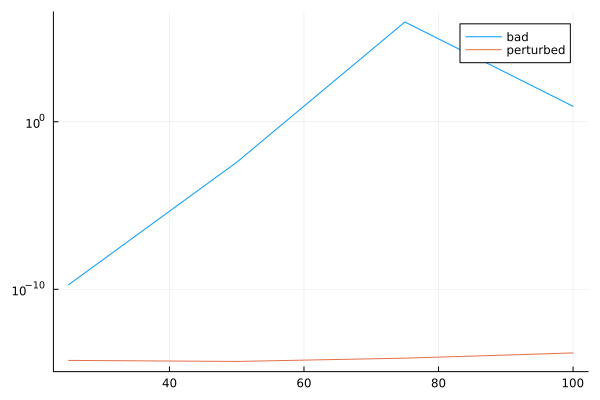

In [16]:
# TODO: plot the error norm(A*(A\b) - b) for the perturbed and unperturbed badmatrix(n).
# What do you observe?
# SOLUTION
baderrs = zeros(4)
perterrs = zeros(4)

for k = 1:4
    n = 25k
    b = randn(n)
    A = badmatrix(n)
    Ã = A + 1E-15*randn(n,n)
    baderrs[k] = norm(A * (A \ b) - b)
    perterrs[k] = norm(Ã * (Ã \ b) - b)
end

plot(25:25:100, baderrs; label="bad", yscale=:log10)
plot!(25:25:100, perterrs; label="perturbed")

# The perturbation errors stay very small, whilst the unperturbed
# errors blow up.
# END

-----

## III.3.3 Cholesky factorisation

The Cholesky factorisation is a special case of LU factorisation for the case
when a matrix is symmetric positive definite (SPD). Hidden in the proof that a Cholesky factorisation
exists if and only if the matrix is SPD is a simple algorithm for computing it:

In [17]:
function mycholesky(A)
    T = eltype(A)
    m,n = size(A)
    if n ≠ m
        error("Matrix must be square")
    end
    if A ≠ A'
        error("Matrix must be symmetric")
    end

    L = LowerTriangular(zeros(T,n,n)) # a lower triangular matrix that at the end will satisfy L'L
    Aⱼ = copy(A)
    for j = 1:n
        α,𝐯 = Aⱼ[1,1],Aⱼ[2:end,1]
        if α ≤ 0
            error("Matrix is not SPD") # this error would be a proof that the matrix is not SPD, if done rigorously
        end
        L[j,j] = sqrt(α)
        L[j+1:end,j] = 𝐯/sqrt(α)

        # induction part
        K = Aⱼ[2:end,2:end] # drop first row and column of A
        Aⱼ = K - 𝐯*𝐯'/α
    end
    L
end

A = Symmetric(rand(100,100) + 100I) # Symmetric takes in a matrix and produces a symmetric version using the upper-triangular part.
L = mycholesky(A)
@test A ≈ L*L'

Test Passed

With exact arithmetic algorithm succeeds if and only if $A$ is symmetric positive definite.
With floating point errors this is not necessarily the case. (One could run it with interval arithmetic
but that would only prove a matrix is SPD if the algorithm succeeded, failure could be caused by
rounding.)

In practice one would normally use the inbuilt `cholesky` function as follows:

In [18]:
L̃ = cholesky(A).L
@test L̃ ≈ L # our implementation matches (approximately) the high-performance implementation.

Test Passed

In the following problem we consider a Cholesky factorisation for tridiagonal matrices. Since we are assuming the
matrix is symmetric, we will use a special type `SymTridiagonal` that captures the symmetry.
In particular, `SymTridiagonal(dv, ev) == Tridiagonal(ev, dv, ev)`.

-----

**Problem 4** Use `mycholesky` or `cholesky` to deduce if the following matrices are SPD.
$$
\begin{bmatrix} 1 & -1  \\
-1 & 3
\end{bmatrix}, \begin{bmatrix} 1 & 2 & 2  \\
2 & 1 & 2\\
2 & 2 & 1
\end{bmatrix}, \begin{bmatrix} 3 & 2 & 1  \\
2 & 4 & 2\\
1 & 2 & 5
\end{bmatrix},
\begin{bmatrix} 4 & 2 & 2 & 1  \\
2 & 4 & 2 & 2\\
2 & 2 & 4 & 2 \\
1 & 2 & 2 & 4
\end{bmatrix}
$$

In [19]:
# TODO: Check if you got PS6 Q1 correct using a computer to do the Cholesky factorisation.
# SOLUTION
cholesky([1 -1; -1 3]) # succeeds so is SPD
cholesky([1 2 2; 2 1 2; 2 2 1]) # throws an error so not SPD
cholesky([3 2 1; 2 4 2; 1 2 5]) # succeeds so is SPD
cholesky([4 2 2 1; 2 4 2 2; 2 2 4 2; 1 2 2 4]) # succeeds so is SPD
# END

PosDefException: PosDefException: matrix is not positive definite; Cholesky factorization failed.

**Problem 5** Complete the following
implementation of `mycholesky` to return a `Bidiagonal` cholesky factor in $O(n)$ operations.

In [20]:
# return a Bidiagonal L such that L'L == A (up to machine precision)
# You are allowed to change A
function mycholesky(A::SymTridiagonal)
    d = A.dv # diagonal entries of A
    u = A.ev # sub/super-diagonal entries of A
    T = float(eltype(A)) # return type, make float in case A has Ints
    n = length(d)
    ld = zeros(T, n) # diagonal entries of L
    ll = zeros(T, n-1) # sub-diagonal entries of L

    # TODO: populate the diagonal entries ld and the sub-diagonal entries ll
    # of L so that L*L' ≈ A
    # SOLUTION
    ld[1] = sqrt(d[1])
    for k = 1:n-1
        ll[k] = u[k]/ld[k]
        ld[k+1] = sqrt(d[k+1]-ll[k]^2)
    end
    # END

    Bidiagonal(ld, ll, :L)
end

n = 1000
A = SymTridiagonal(2*ones(n),-ones(n-1))
L = mycholesky(A)
@test L isa Bidiagonal
@test L*L' ≈ A

Test Passed

## III.4 Polynomial Interpolation and Regression

We now explore the practical usage of polynomial interpolation and regression.
In particular we will see that polynomial interpolation may fail as the number
of points becomes large.

### III.4.1 Polynomial Interpolation

A quick-and-dirty way to to do interpolation is to invert the Vandermonde matrix.
That is, for
$$
p(x) = ∑_{k = 0}^{n-1} c_k x^k
$$
and $x_1, …, x_n ∈ ℝ$, we choose $c_k$ so that $p(x_j) = f(x_j)$ for
$j = 1, …, n$. We do so by creating the square Vandermonde matrix
$$
V := \begin{bmatrix} 1 & x_1 & ⋯ & x_1^{n-1} \\
                    ⋮ & ⋮ & ⋱ & ⋮ \\
                    1 & x_n & ⋯ & x_n^{n-1}
                    \end{bmatrix}.
$$
If the function samples are
$$
 𝐟 = \begin{bmatrix} f(x_1) \\ ⋮ \\ f(x_n) \end{bmatrix}
$$
then the coefficients of the interpolatory polynomial
$$
      𝐜 = \begin{bmatrix}
          c_0 \\ ⋮ \\ c_{n-1} \end{bmatrix}
$$
must satisfy $V 𝐜 = 𝐟$.  Thus inverting the Vandermonde matrix tells us the coefficients.

Here we see an example of this using `n` evenly spaced points:

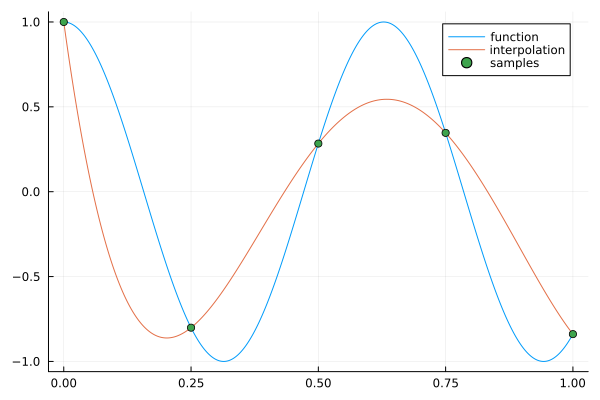

In [21]:
f = x -> cos(10x)
n = 5
𝐱 = range(0, 1; length=n) # evenly spaced points (BAD for interpolation)
V =  [𝐱[j]^k for j = 1:n, k = 0:n-1] # Vandermonde matrix, also can be written as x .^ (0:n)'
𝐟 = f.(𝐱) # evaluate f at x[k], equivalent to [f(x[k]) for k = 1:n]
𝐜 = V \ 𝐟 # invert the Vandermonde matrix and determine the coefficients
p = x -> dot(𝐜, x .^ (0:n-1)) # take a dot product with monomials x .^ 0:n-1 == [x^j for j=0:n-1]
@test p.(𝐱) ≈ V * 𝐜 # evaluating the polynomial on x is the same as applying V


𝐠 = range(0,1; length=1000) # plotting grid, sample a lot more than interpolation points

# To evaluate a polynomial on the plotting grid its faster to create the rectangular Vandermonde matrix associated with that grid:
V_g = [𝐠[j]^k for j = 1:length(𝐠), k = 0:n-1]

plot(𝐠, f.(𝐠); label="function")
plot!(𝐠, V_g*𝐜; label="interpolation")
scatter!(𝐱, f.(𝐱); label="samples")

Whether an interpolation is actually close to a function is a subtle question,
involving properties of the function, distribution of the sample points $x_1,…,x_n$,
and round-off error.
A classic example is:
$$
  f_M(x) = {1 \over M x^2 + 1}
$$
where the choice of $M$ can dictate whether interpolation at evenly spaced points converges.

-------

**Problem 6(a)** Interpolate $1/(4x^2+1)$ and $1/(25x^2 + 1)$ at an evenly spaced grid of $n$
points, plotting the solution at a grid of $1000$ points. For $n = 50$ does your interpolation match
the true function?  Does increasing $n$ to 400 improve the accuracy? How about using `BigFloat`?
Hint: make sure to make your `range` be `BigFloat` valued, e.g., `range(big(-1), big(1); length=n)`.

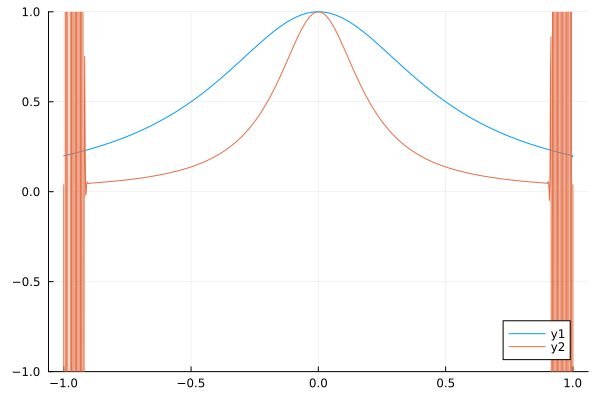

In [22]:
# TODO: interpolate 1/(10x^2 + 1) and 1/(25x^2 + 1) at $n$ evenly spaced points, plotting both solutions evaluated at
# the plotting grid with 1000 points, for $n = 50$ and $400$.

# SOLUTION

n = 50
𝐱 = range(-1, 1; length=n)
𝐠 = range(-1, 1; length=1000) # plotting grid

V = 𝐱 .^ (0:n-1)'
V_g = 𝐠 .^ (0:n-1)'

f_4 = x -> 1/(4x^2 + 1)
𝐜_4 = V \ f_4.(𝐱)
f_25 = x -> 1/(25x^2 + 1)
𝐜_25 = V \ f_25.(𝐱)

plot(𝐠, V_g*𝐜_4; ylims=(-1,1))
plot!(𝐠, V_g*𝐜_25)
# We see large errors near ±1 for both examples.


n = 400
𝐱 = range(-1, 1; length=n)

V = 𝐱 .^ (0:n-1)'
V_g = 𝐠 .^ (0:n-1)'
f_4 = x -> 1/(4x^2 + 1)
𝐜_4 = V \ f_4.(𝐱)
f_25 = x -> 1/(25x^2 + 1)
𝐜_25 = V \ f_25.(𝐱)

plot(𝐠, V_g*𝐜_4; ylims=(-1,1))
plot!(𝐠, V_g*𝐜_25)
#  M = 4 appears to converge whilst M = 25 breaks down.

# Now do big float
n = 400
𝐱 = range(big(-1), 1; length=n)
𝐠 = range(big(-1), 1; length=1000) # plotting grid

V = 𝐱 .^ (0:n-1)'
V_g = 𝐠 .^ (0:n-1)'

f_4 = x -> 1/(4x^2 + 1)
𝐜_4 = V \ f_4.(𝐱)
f_25 = x -> 1/(25x^2 + 1)
𝐜_25 = V \ f_25.(𝐱)

plot(𝐠, V_g*𝐜_4; ylims=(-1,1))
plot!(𝐠, V_g*𝐜_25)
# With M = 4 it looks like it now is converging. This suggests the issue before was numerical error.
# For M = 25 the solution is even less accurate, which suggests the issue is a lack of mathematical
# convergence.

# END

------

### III.4.2 Polynomial regression

To overcome issues with interpolation we will instead use regression: use more points than
the degree of the polynomial. As an example, suppose we want to fit noisy data by a quadratic
$$
p(x) = c₀ + c₁ x + c₂ x^2
$$
That is, we want to choose $c₀,c₁,c₂$ at data samples $x_1, …, x_m$ so that the following is true:
$$
c₀ + c₁ x_j + c₂ x_j^2 ≈ f_j
$$
where $f_j$ are given by data. We can reinterpret this as a least squares problem: minimise the norm
$$
\left\| \begin{bmatrix} 1 & x_1 & x_1^2 \\ ⋮ & ⋮ & ⋮ \\ 1 & x_m & x_m^2 \end{bmatrix}
\begin{bmatrix} p₀ \\ p₁ \\ p₂ \end{bmatrix} - \begin{bmatrix} f_1 \\ ⋮ \\ f_m \end{bmatrix} \right \|
$$
When a matrix is rectangular `\` solves a least squares problem for us:

In [23]:
m,n = 100,3

𝐱 = range(0,1; length=m) # 100 points
𝐟 = 2 .+ 𝐱 .+ 2𝐱.^2 .+ 0.1 .* randn.() # Noisy quadratic samples, built with broadcast notation.

V = 𝐱 .^ (0:2)'  # 100 x 3 Vandermonde matrix, equivalent to [ones(m) x x.^2]

𝐜 = V \ 𝐟 # coefficients are, very roughly, [2,1,2]

3-element Vector{Float64}:
 2.0269217812595146
 0.7743628993983587
 2.22356386897485

We can visualise the fit:

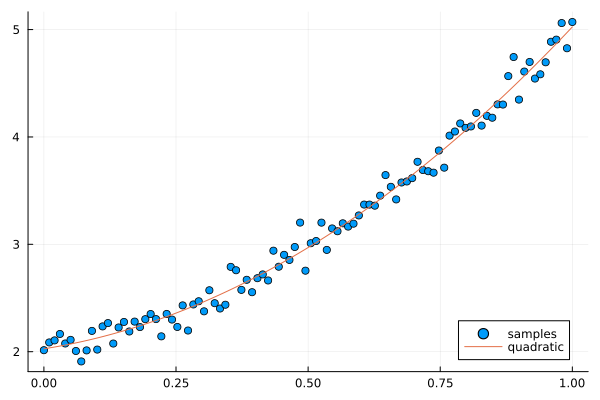

In [24]:
𝐠 =range(0, 1; length=1000)

p = x -> 𝐜[1] + 𝐜[2]x + 𝐜[3]x^2

scatter(𝐱, 𝐟; label="samples", legend=:bottomright)
plot!(𝐠, p.(𝐠); label="quadratic")

-----

**Problem 6(b)** Repeat the previous problem but now using _least squares_: instead of interpolating,
use least squares on a large grid: choose the coefficients of a degree $(n-1)$ polynomial so that
$$
    \left\| \begin{bmatrix} p(x_1) \\ ⋮ \\ p(x_m) \end{bmatrix} - \begin{bmatrix} f(x_1) \\ ⋮ \\ f(x_m) \end{bmatrix} \right \|.
$$
is minimised, where $n = 50$ and $m = 500$.
Does this improve the accuracy near the endpoints? Do you think convergence for a least squares approximation
is dictated by the radius of convergence of the corresponding Taylor series?
Hint: use the rectangular Vandermonde matrix to setup the Least squares system.

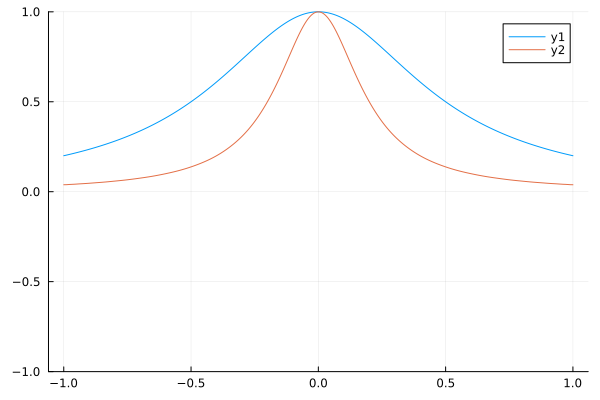

In [25]:
# TODO: approximate 1/(10x^2 + 1) and 1/(25x^2 + 1) using a least squares system where the

# SOLUTION
n = 50 # use basis [1,x,…,x^(49)]
𝐱 = range(-1, 1; length=500) # least squares grid
𝐠 = range(-1, 1; length=2000) # plotting grid

V = 𝐱 .^ (0:n-1)'
V_g = 𝐠 .^ (0:n-1)'
f_4 = x -> 1/(4x^2 + 1)
𝐜_4 = V \ f_4.(𝐱)
f_25 = x -> 1/(25x^2 + 1)
𝐜_25 = V \ f_25.(𝐱)

plot(𝐠, V_g*𝐜_4; ylims=(-1,1))
plot!(𝐠, V_g*𝐜_25)

# Yes, now both approximations appear to be converging.
# This is despite the radius of convergence of both functions being
# smaller than the interval of interpolation.

# END

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*